<a href="https://colab.research.google.com/drive/14GTXbBuO9quCIHIqQXcCoIHWNzQFK-x6?usp=sharing" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import time as time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# CSV file path setup
Please modify the file path correctly.<br>
실행하기 전 파일 경로를 알맞게 지정해주세요.

In [ ]:
mon_features25 = pd.read_csv('/content/drive/MyDrive/mon_features25.csv')
mon_label = pd.read_csv('/content/drive/MyDrive/mon_label.csv')
unmon_features25 = pd.read_csv('/content/drive/MyDrive/unmon_features25.csv')
unmon_label = pd.read_csv('/content/drive/MyDrive/unmon_label.csv')

# Data Preprocessing

In [ ]:
features25 = pd.concat([mon_features25, unmon_features25], axis=0, ignore_index=True)
labels = pd.concat([mon_label, unmon_label], axis=0, ignore_index=True)

labels[labels == 'unmonitored'] = -1

In [ ]:
print(features25.dtypes)

num_total_packets                       int64
sum_packets                             int64
num_incoming_packets                    int64
frac_incoming_packets                 float64
num_outgoing_packets                    int64
frac_outgoing_packets                 float64
cumulative_packet_size_seq             object
packet_size_ratios                    float64
burst_lengths                           int64
burst_seq                              object
average_incoming_ordering             float64
std_dev_incoming_ordering             float64
average_outgoing_ordering             float64
std_dev_outgoing_ordering             float64
avg_packet_size                       float64
max_packet_size                         int64
avg_inter_arrival_time                float64
var_packet_size                       float64
alternative_packets_per_second_sum    float64
num_packets_per_second                float64
mean_packets_per_second               float64
std_packets_per_second            

In [ ]:
features25 = features25.drop(['cumulative_packet_size_seq', 'burst_seq'], axis=1)
print(features25.head())

   num_total_packets  sum_packets  num_incoming_packets  \
0               1421       727552                  1300   
1                518       265216                   438   
2               1358       695296                  1240   
3               1446       740352                  1324   
4               1406       719872                  1291   

   frac_incoming_packets  num_outgoing_packets  frac_outgoing_packets  \
0               0.914849                   121               0.085151   
1               0.845560                    80               0.154440   
2               0.913108                   118               0.086892   
3               0.915629                   122               0.084371   
4               0.918208                   115               0.081792   

   packet_size_ratios  burst_lengths  average_incoming_ordering  \
0            0.093077            156                 704.106154   
1            0.182648             94                 264.406393   
2    

# 1. Before Fine Tuning

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(features25, labels, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

Validation Accuracy: 0.69
Precision: 0.71
Recall: 0.69
F1 Score: 0.69
Confusion Matrix:
 [[278   3   0 ...   3   1   4]
 [  5  17   0 ...   1   0   0]
 [  3   0  16 ...   0   0   0]
 ...
 [  5   0   0 ...  17   0   0]
 [  3   0   0 ...   0  27   0]
 [  6   0   0 ...   0   0  16]]


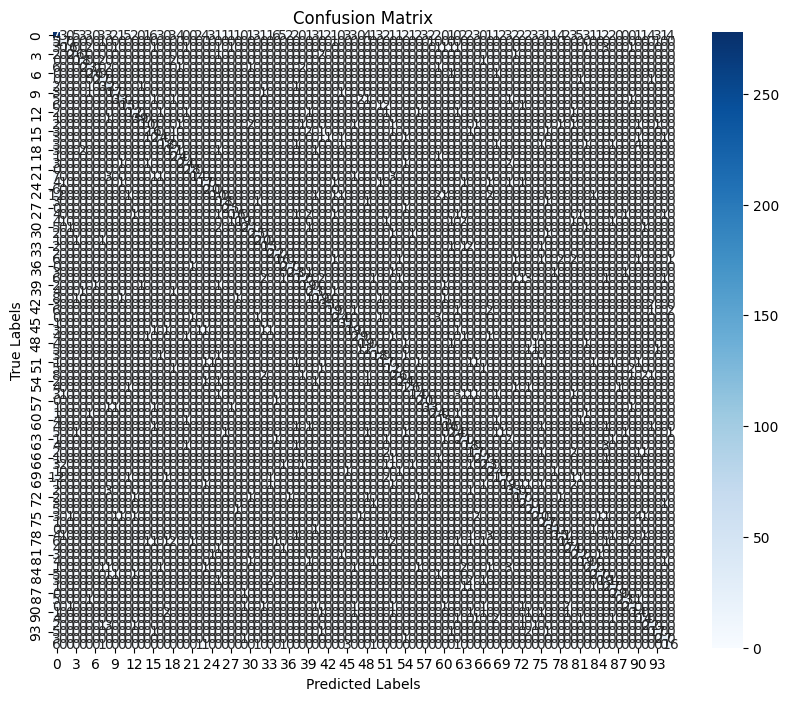


Execution Time: 0.65 minutes


In [ ]:
start_time = time.time()

# Train a RandomForest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_valid_pred = rf_model.predict(X_val)

# Valid Accuracy
valid_accuracy = accuracy_score(y_val, y_valid_pred)
print(f'Validation Accuracy: {valid_accuracy:.2f}')

# Precision, Recall, F1-Score (Weighted for multi-class)
precision = precision_score(y_val, y_valid_pred, average='weighted')
recall = recall_score(y_val, y_valid_pred, average='weighted')
f1 = f1_score(y_val, y_valid_pred, average='weighted')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_valid_pred)
print("Confusion Matrix:\n", conf_matrix)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

end_time = time.time()
print(f"\nExecution Time: {(end_time - start_time)/60:.2f} minutes")

In [ ]:
# Function to count values in each range
def count_in_ranges(values, ranges):
    counts = {}
    for low, high in ranges:
        if high == 1.0:  # Include the upper boundary for the last range
            count = sum(low <= val <= high for val in values)
        else:
            count = sum(low <= val < high for val in values)
        counts[f"{low:.1f} to {high:.1f}"] = count
    return counts

# Ranges for evaluation
ranges = [(0.9, 1.0), (0.8, 0.9), (0.7, 0.8), (0.6, 0.7), (0.0, 0.6)]

# Generate Classification Report
class_report_dict = classification_report(y_val, y_valid_pred, output_dict=True, target_names=[str(i) for i in range(95)] + ['unmonitored'])

# Extract Precision, Recall, and F1 values for all classes (excluding the 'accuracy' entry)
precision = [class_report_dict[str(i)]['precision'] for i in range(95)] + [class_report_dict['unmonitored']['precision']]
recall = [class_report_dict[str(i)]['recall'] for i in range(95)] + [class_report_dict['unmonitored']['recall']]
f1 = [class_report_dict[str(i)]['f1-score'] for i in range(95)] + [class_report_dict['unmonitored']['f1-score']]

# Count classes in each range for precision, recall, and F1
precision_counts = count_in_ranges(precision, ranges)
recall_counts = count_in_ranges(recall, ranges)
f1_counts = count_in_ranges(f1, ranges)

# Print counts for precision
print("\nPrecision Ranges:")
for r, count in precision_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for recall
print("\nRecall Ranges:")
for r, count in recall_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for F1-Score
print("\nF1-Score Ranges:")
for r, count in f1_counts.items():
    print(f"  {r}: {count} classes")



Precision Ranges:
  0.9 to 1.0: 10 classes
  0.8 to 0.9: 21 classes
  0.7 to 0.8: 29 classes
  0.6 to 0.7: 26 classes
  0.0 to 0.6: 10 classes

Recall Ranges:
  0.9 to 1.0: 13 classes
  0.8 to 0.9: 16 classes
  0.7 to 0.8: 20 classes
  0.6 to 0.7: 25 classes
  0.0 to 0.6: 22 classes

F1-Score Ranges:
  0.9 to 1.0: 9 classes
  0.8 to 0.9: 17 classes
  0.7 to 0.8: 26 classes
  0.6 to 0.7: 26 classes
  0.0 to 0.6: 18 classes


# 2. Fine Tuning

## RFE(Recursive Feature Elimination) for Feature Selection

In [ ]:
# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Retrieve feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features25.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importances:")
print(feature_importance_df)

# Identify features with zero importance
zero_importance_features = feature_importance_df[feature_importance_df['Importance'] == 0]['Feature'].tolist()
print(f"\nFeatures with zero importance: {zero_importance_features}")

# Optional: Drop features with zero importance
features25 = features25.drop(zero_importance_features, axis=1)

Feature Importances:
                               Feature  Importance
10           average_outgoing_ordering    0.079256
11           std_dev_outgoing_ordering    0.070351
7                        burst_lengths    0.064304
9            std_dev_incoming_ordering    0.057867
4                 num_outgoing_packets    0.057531
8            average_incoming_ordering    0.057468
3                frac_incoming_packets    0.056853
5                frac_outgoing_packets    0.056396
6                   packet_size_ratios    0.055228
2                 num_incoming_packets    0.055088
0                    num_total_packets    0.054269
1                          sum_packets    0.053653
14              avg_inter_arrival_time    0.052933
17              num_packets_per_second    0.050698
19              std_packets_per_second    0.050503
20              med_packets_per_second    0.033881
18             mean_packets_per_second    0.033040
22           num_packets_longest_burst    0.031860
16  altern

## GridSearchCv

In [ ]:
param_grid = {
    'n_estimators': [200, 400, 600],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
}

start_time = time.time()

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

end_time = time.time()

print("Best Parameters:", grid_search.best_params_)
print(f"\nExecution Time: {(end_time - start_time)/60:.2f} minutes")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

Execution Time: 48.18 minutes


In [ ]:
fixed_params = {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1}

param_grid = {
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, **fixed_params),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

print("Best Parameters:", grid_search.best_params_)
print(f"\nExecution Time: {(end_time - start_time)/60:.2f} minutes")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt'}

Execution Time: 13.25 minutes


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(features25, labels, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [ ]:
rf_model_grid1 = RandomForestClassifier(
    n_estimators=400,          # 최적값: 트리 개수
    min_samples_split=2,       # 최적값: 노드 분할 최소 샘플 수
    min_samples_leaf=1,        # 최적값: 노드 최소 leaf 수
    max_depth=30,              # 최적값: 트리 최대 깊이
    max_features='sqrt',       # 최적값: 노드에서 사용할 최대 특징 수
    bootstrap=True,            # 최적값: 부트스트랩 사용 여부
    random_state=42            # 랜덤 시드
)

start_time = time.time()

rf_model_grid1.fit(X_train, y_train)

end_time = time.time()
print(f"\nExecution Time: {(end_time - start_time)/60:.2f} minutes")


Execution Time: 1.49 minutes


Validation Accuracy: 0.70
Precision: 0.71
Recall: 0.70
F1-Score: 0.70

Confusion Matrix:
[[282   2   0 ...   3   0   2]
 [  4  17   0 ...   1   0   0]
 [  2   0  15 ...   0   0   0]
 ...
 [  5   0   0 ...  17   0   0]
 [  3   0   0 ...   0  26   0]
 [  8   0   0 ...   0   0  15]]


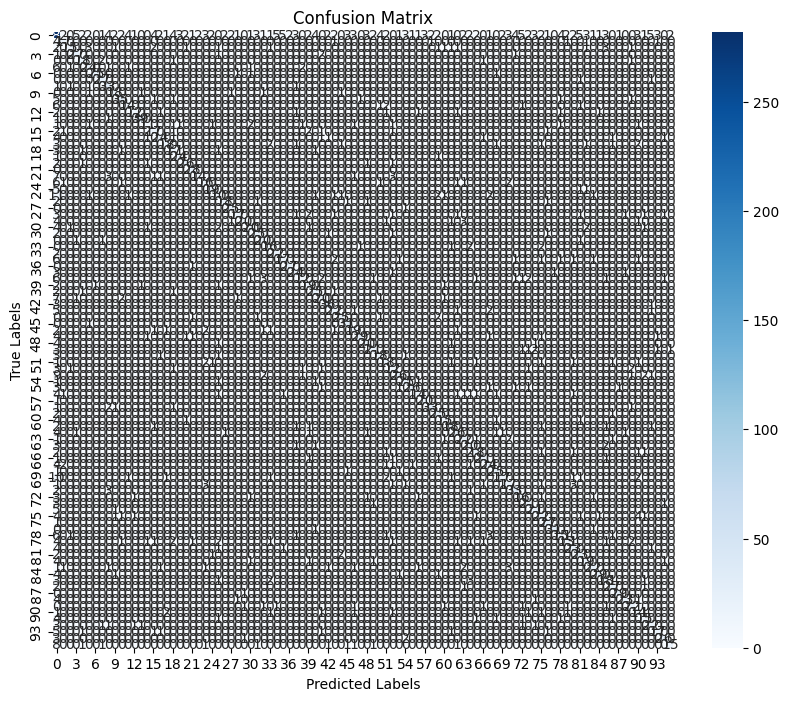

In [ ]:
# 검증 데이터 평가
y_val_pred = rf_model_grid1.predict(X_val)

# Validation Accuracy
valid_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {valid_accuracy:.2f}")

# Precision, Recall, F1-Score (Weighted)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Function to count values in each range
def count_in_ranges(values, ranges):
    counts = {}
    for low, high in ranges:
        if high == 1.0:  # Include the upper boundary for the last range
            count = sum(low <= val <= high for val in values)
        else:
            count = sum(low <= val < high for val in values)
        counts[f"{low:.1f} to {high:.1f}"] = count
    return counts

# Ranges for evaluation
ranges = [(0.9, 1.0), (0.8, 0.9), (0.7, 0.8), (0.6, 0.7), (0.0, 0.6)]

# Generate Classification Report
class_report_dict = classification_report(y_val, y_val_pred, output_dict=True, target_names=[str(i) for i in range(95)] + ['unmonitored'])

# Extract Precision, Recall, and F1 values for all classes (excluding the 'accuracy' entry)
precision = [class_report_dict[str(i)]['precision'] for i in range(95)] + [class_report_dict['unmonitored']['precision']]
recall = [class_report_dict[str(i)]['recall'] for i in range(95)] + [class_report_dict['unmonitored']['recall']]
f1 = [class_report_dict[str(i)]['f1-score'] for i in range(95)] + [class_report_dict['unmonitored']['f1-score']]

# Count classes in each range for precision, recall, and F1
precision_counts = count_in_ranges(precision, ranges)
recall_counts = count_in_ranges(recall, ranges)
f1_counts = count_in_ranges(f1, ranges)

# Print counts for precision
print("\nPrecision Ranges:")
for r, count in precision_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for recall
print("\nRecall Ranges:")
for r, count in recall_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for F1-Score
print("\nF1-Score Ranges:")
for r, count in f1_counts.items():
    print(f"  {r}: {count} classes")



Precision Ranges:
  0.9 to 1.0: 8 classes
  0.8 to 0.9: 25 classes
  0.7 to 0.8: 29 classes
  0.6 to 0.7: 25 classes
  0.0 to 0.6: 9 classes

Recall Ranges:
  0.9 to 1.0: 13 classes
  0.8 to 0.9: 20 classes
  0.7 to 0.8: 20 classes
  0.6 to 0.7: 23 classes
  0.0 to 0.6: 20 classes

F1-Score Ranges:
  0.9 to 1.0: 9 classes
  0.8 to 0.9: 20 classes
  0.7 to 0.8: 24 classes
  0.6 to 0.7: 30 classes
  0.0 to 0.6: 13 classes


## Stratified k-Fold Cross-Validation => 최종 모델로 선택

In [ ]:
# Define the model
rf_model_base = RandomForestClassifier(random_state=42)

# Set up Stratified k-Fold Cross-Validation
n_splits = 10  # Number of folds (adjustable)
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store performance metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

start_time = time.time()

# Perform Stratified k-Fold Cross-Validation
for train_index, val_index in skf.split(features25, labels):
    # Split data
    X_train, X_val = features25.iloc[train_index], features25.iloc[val_index]
    y_train, y_val = labels.iloc[train_index], labels.iloc[val_index]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Train the model
    rf_model_base.fit(X_train, y_train.values.ravel())

    # Predict on validation set
    y_val_pred = rf_model_base.predict(X_val)

    # Compute metrics
    accuracy_scores.append(accuracy_score(y_val, y_val_pred))
    precision_scores.append(precision_score(y_val, y_val_pred, average='weighted'))
    recall_scores.append(recall_score(y_val, y_val_pred, average='weighted'))
    f1_scores.append(f1_score(y_val, y_val_pred, average='weighted'))

end_time = time.time()

# Compute average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Display results
print(f"Stratified k-Fold Cross-Validation Results ({n_splits} folds):")
print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average Precision: {average_precision:.2f}")
print(f"Average Recall: {average_recall:.2f}")
print(f"Average F1-Score: {average_f1:.2f}")

print(f"\nExecution Time: {(end_time - start_time)/60:.2f} minutes")

Stratified k-Fold Cross-Validation Results (10 folds):
Average Accuracy: 0.73
Average Precision: 0.74
Average Recall: 0.73
Average F1-Score: 0.73

Execution Time: 4.45 minutes


In [ ]:
# Function to count values in each range
def count_in_ranges(values, ranges):
    counts = {}
    for low, high in ranges:
        if high == 1.0:  # Include the upper boundary for the last range
            count = sum(low <= val <= high for val in values)
        else:
            count = sum(low <= val < high for val in values)
        counts[f"{low:.1f} to {high:.1f}"] = count
    return counts

# Ranges for evaluation
ranges = [(0.9, 1.0), (0.8, 0.9), (0.7, 0.8), (0.6, 0.7), (0.0, 0.6)]

# Generate Classification Report
class_report_dict = classification_report(y_val, y_val_pred, output_dict=True, target_names=[str(i) for i in range(95)] + ['unmonitored'])

# Extract Precision, Recall, and F1 values for all classes (excluding the 'accuracy' entry)
precision = [class_report_dict[str(i)]['precision'] for i in range(95)] + [class_report_dict['unmonitored']['precision']]
recall = [class_report_dict[str(i)]['recall'] for i in range(95)] + [class_report_dict['unmonitored']['recall']]
f1 = [class_report_dict[str(i)]['f1-score'] for i in range(95)] + [class_report_dict['unmonitored']['f1-score']]

# Count classes in each range for precision, recall, and F1
precision_counts = count_in_ranges(precision, ranges)
recall_counts = count_in_ranges(recall, ranges)
f1_counts = count_in_ranges(f1, ranges)

# Print counts for precision
print("\nPrecision Ranges:")
for r, count in precision_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for recall
print("\nRecall Ranges:")
for r, count in recall_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for F1-Score
print("\nF1-Score Ranges:")
for r, count in f1_counts.items():
    print(f"  {r}: {count} classes")



Precision Ranges:
  0.9 to 1.0: 18 classes
  0.8 to 0.9: 26 classes
  0.7 to 0.8: 29 classes
  0.6 to 0.7: 13 classes
  0.0 to 0.6: 10 classes

Recall Ranges:
  0.9 to 1.0: 17 classes
  0.8 to 0.9: 25 classes
  0.7 to 0.8: 17 classes
  0.6 to 0.7: 24 classes
  0.0 to 0.6: 13 classes

F1-Score Ranges:
  0.9 to 1.0: 13 classes
  0.8 to 0.9: 24 classes
  0.7 to 0.8: 27 classes
  0.6 to 0.7: 23 classes
  0.0 to 0.6: 9 classes


## GridSearchCV + Stratified k-Fold Cross-Validation

In [ ]:
# Define the model
rf_model = RandomForestClassifier(
    n_estimators=400,          # 최적값: 트리 개수
    min_samples_split=2,       # 최적값: 노드 분할 최소 샘플 수
    min_samples_leaf=1,        # 최적값: 노드 최소 leaf 수
    max_depth=30,              # 최적값: 트리 최대 깊이
    max_features='sqrt',       # 최적값: 노드에서 사용할 최대 특징 수
    bootstrap=True,            # 최적값: 부트스트랩 사용 여부
    random_state=42            # 랜덤 시드
)

# Set up Stratified k-Fold Cross-Validation
n_splits = 10  # Number of folds (adjustable)
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store performance metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

start_time = time.time()

# Perform Stratified k-Fold Cross-Validation
for train_index, val_index in skf.split(features25, labels):
    # Split data
    X_train, X_val = features25.iloc[train_index], features25.iloc[val_index]
    y_train, y_val = labels.iloc[train_index], labels.iloc[val_index]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Train the model
    rf_model.fit(X_train, y_train.values.ravel())

    # Predict on validation set
    y_val_pred = rf_model.predict(X_val)

    # Compute metrics
    accuracy_scores.append(accuracy_score(y_val, y_val_pred))
    precision_scores.append(precision_score(y_val, y_val_pred, average='weighted'))
    recall_scores.append(recall_score(y_val, y_val_pred, average='weighted'))
    f1_scores.append(f1_score(y_val, y_val_pred, average='weighted'))

end_time = time.time()

# Compute average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Display results
print(f"Stratified k-Fold Cross-Validation Results ({n_splits} folds):")
print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average Precision: {average_precision:.2f}")
print(f"Average Recall: {average_recall:.2f}")
print(f"Average F1-Score: {average_f1:.2f}")

print(f"\nExecution Time: {(end_time - start_time)/60:.2f} minutes")

Stratified k-Fold Cross-Validation Results (10 folds):
Average Accuracy: 0.73
Average Precision: 0.74
Average Recall: 0.73
Average F1-Score: 0.73

Execution Time: 17.25 minutes


In [ ]:
# Function to count values in each range
def count_in_ranges(values, ranges):
    counts = {}
    for low, high in ranges:
        if high == 1.0:  # Include the upper boundary for the last range
            count = sum(low <= val <= high for val in values)
        else:
            count = sum(low <= val < high for val in values)
        counts[f"{low:.1f} to {high:.1f}"] = count
    return counts

# Ranges for evaluation
ranges = [(0.9, 1.0), (0.8, 0.9), (0.7, 0.8), (0.6, 0.7), (0.0, 0.6)]

# Generate Classification Report
class_report_dict = classification_report(y_val, y_val_pred, output_dict=True, target_names=[str(i) for i in range(95)] + ['unmonitored'])

# Extract Precision, Recall, and F1 values for all classes (excluding the 'accuracy' entry)
precision = [class_report_dict[str(i)]['precision'] for i in range(95)] + [class_report_dict['unmonitored']['precision']]
recall = [class_report_dict[str(i)]['recall'] for i in range(95)] + [class_report_dict['unmonitored']['recall']]
f1 = [class_report_dict[str(i)]['f1-score'] for i in range(95)] + [class_report_dict['unmonitored']['f1-score']]

# Count classes in each range for precision, recall, and F1
precision_counts = count_in_ranges(precision, ranges)
recall_counts = count_in_ranges(recall, ranges)
f1_counts = count_in_ranges(f1, ranges)

# Print counts for precision
print("\nPrecision Ranges:")
for r, count in precision_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for recall
print("\nRecall Ranges:")
for r, count in recall_counts.items():
    print(f"  {r}: {count} classes")

# Print counts for F1-Score
print("\nF1-Score Ranges:")
for r, count in f1_counts.items():
    print(f"  {r}: {count} classes")



Precision Ranges:
  0.9 to 1.0: 14 classes
  0.8 to 0.9: 32 classes
  0.7 to 0.8: 22 classes
  0.6 to 0.7: 20 classes
  0.0 to 0.6: 8 classes

Recall Ranges:
  0.9 to 1.0: 18 classes
  0.8 to 0.9: 25 classes
  0.7 to 0.8: 17 classes
  0.6 to 0.7: 26 classes
  0.0 to 0.6: 10 classes

F1-Score Ranges:
  0.9 to 1.0: 12 classes
  0.8 to 0.9: 26 classes
  0.7 to 0.8: 24 classes
  0.6 to 0.7: 26 classes
  0.0 to 0.6: 8 classes


## Test Set Accuracy

In [ ]:
y_test_pred = rf_model_base.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Precision & Recall
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Test Accuracy: 0.92
Precision: 0.93
Recall: 0.92
F1-Score: 0.92



Confusion Matrix:
[[403   2   1 ...   0   0   0]
 [  1  27   0 ...   0   0   0]
 [  0   0  37 ...   0   0   0]
 ...
 [  6   0   0 ...  27   0   1]
 [  0   0   0 ...   0  27   0]
 [  3   1   1 ...   0   0  22]]


<function matplotlib.pyplot.show(close=None, block=None)>

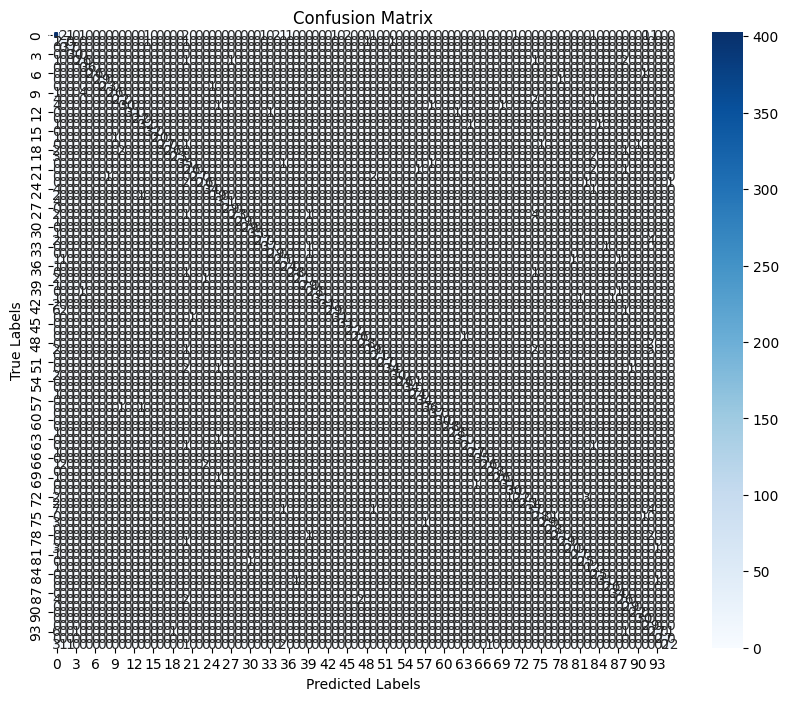

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show